# COSINE SIMILARITY SEARCH

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

2.2.0


### READ IMAGES

Found [432] images


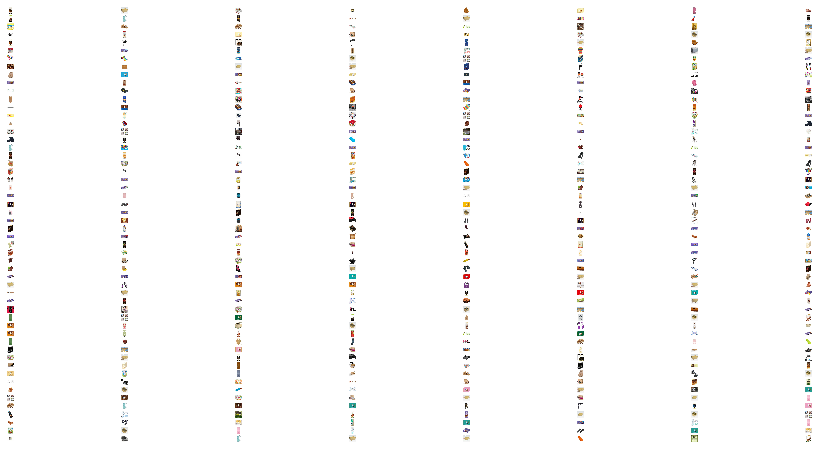

In [2]:
image_paths = glob.glob('FinalImages/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

### COSINE IMPLEMENTATION

In [4]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

100%|██████████| 432/432 [03:20<00:00,  2.15it/s]


In [19]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]
    
#     f, ax = plt.subplots(1, max_results, figsize=(16, 8))
#     for i, img in enumerate(sorted_neighbors[:max_results]):
#         ax[i].imshow(images[img[0]])
#         ax[i].set_axis_off()
    
#     plt.show()

In [21]:
search_by_style("6438372_1.jpg")

[('6438372_1.jpg', 0.0),
 ('2601997_0.jpg', 0.0271378755569458),
 ('2894006_0.jpg', 0.032693684101104736),
 ('395560_0.jpg', 0.03337305784225464),
 ('6505789_0.jpg', 0.03369283676147461),
 ('6438372_0.jpg', 0.03945893049240112),
 ('6080959_2.jpg', 0.0395127534866333),
 ('6080959_0.jpg', 0.0395127534866333),
 ('2797132_1.jpg', 0.04026097059249878),
 ('6080959_3.jpg', 0.04083669185638428),
 ('6080959_1.jpg', 0.04083669185638428)]

### EXTRACT OUTPUT INTO CSV

In [20]:
imagenames = [search_by_style(image_name) for image_name in images.keys()]

In [22]:
imagename = pd.DataFrame(imagenames)
imagename

,0,1,2,3,4,5,6,7,8,9,10
0,"(6621993_1.jpg, 0.0)","(5531218_0.jpg, 0.011563122272491455)","(5076193_0.jpg, 0.011594951152801514)","(3592570_1.jpg, 0.016013681888580322)","(5237851_0.jpg, 0.019992351531982422)","(1360443_1.jpg, 0.020024418830871582)","(2795694_0.jpg, 0.02135908603668213)","(1211240_0.jpg, 0.02418982982635498)","(5962041_0.jpg, 0.02432650327682495)","(1422091_0.jpg, 0.024565517902374268)","(1576123_1.jpg, 0.02530771493911743)"
1,"(598876_0.jpg, 0.0)","(3779080_2.jpg, 0.0)","(5057350_0.jpg, 0.0)","(3518216_0.jpg, 0.0)","(5430819_0.jpg, 0.0)","(5805839_1.jpg, 0.0011521577835083008)","(3766409_1.jpg, 0.0011521577835083008)","(5299557_1.jpg, 0.0038114190101623535)","(598876_1.jpg, 0.004948258399963379)","(3779080_0.jpg, 0.004948258399963379)","(5057350_2.jpg, 0.004948258399963379)"
2,"(3169236_0.jpg, 0.0)","(3169236_1.jpg, 0.0005500316619873047)","(3945315_0.jpg, 0.026449739933013916)","(263977_1.jpg, 0.030438542366027832)","(2070927_0.jpg, 0.03171110153198242)","(2527501_0.jpg, 0.03216087818145752)","(1707110_1.jpg, 0.03723174333572388)","(4285581_0.jpg, 0.03749871253967285)","(4207944_0.jpg, 0.03774607181549072)","(4412540_0.jpg, 0.03834354877471924)","(2755487_0.jpg, 0.03870576620101929)"
3,"(3391830_3.jpg, 0.0)","(3761227_0.jpg, 0.016215384006500244)","(1579564_0.jpg, 0.016468822956085205)","(5076193_0.jpg, 0.02057701349258423)","(2795694_0.jpg, 0.021317601203918457)","(766234_0.jpg, 0.022368788719177246)","(4530827_0.jpg, 0.02285909652709961)","(1211240_0.jpg, 0.024288713932037354)","(217204_0.jpg, 0.024465978145599365)","(2261625_0.jpg, 0.02446913719177246)","(5880137_0.jpg, 0.024842798709869385)"
4,"(6359436_2.jpg, 0.0)","(6359436_1.jpg, 0.010558366775512695)","(1926144_0.jpg, 0.01499098539352417)","(3007801_0.jpg, 0.01499098539352417)","(4418633_0.jpg, 0.018104970455169678)","(2853133_0.jpg, 0.018104970455169678)","(6249716_0.jpg, 0.020035505294799805)","(3061333_1.jpg, 0.022721946239471436)","(6359436_0.jpg, 0.023004651069641113)","(6203447_1.jpg, 0.024057865142822266)","(217204_0.jpg, 0.02442920207977295)"
...,...,...,...,...,...,...,...,...,...,...,...
427,"(598876_0.jpg, 0.0)","(3779080_2.jpg, 0.0)","(5057350_0.jpg, 0.0)","(3518216_0.jpg, 0.0)","(5430819_0.jpg, 0.0)","(5805839_1.jpg, 0.0011521577835083008)","(3766409_1.jpg, 0.0011521577835083008)","(5299557_1.jpg, 0.0038114190101623535)","(598876_1.jpg, 0.004948258399963379)","(3779080_0.jpg, 0.004948258399963379)","(5057350_2.jpg, 0.004948258399963379)"
428,"(6357292_0.jpg, 0.0)","(948745_0.jpg, 0.0)","(417077_0.jpg, 0.00026023387908935547)","(5805839_0.jpg, 0.0051427483558654785)","(3766409_0.jpg, 0.005162537097930908)","(3779080_1.jpg, 0.006317019462585449)","(5057350_1.jpg, 0.006317019462585449)","(3518216_1.jpg, 0.006317019462585449)","(598876_2.jpg, 0.006373584270477295)","(5430819_2.jpg, 0.006373584270477295)","(5299557_0.jpg, 0.0067237019538879395)"
429,"(3809087_0.jpg, 0.0)","(6019869_0.jpg, 0.0)","(664385_2.jpg, 0.0566747784614563)","(238697_2.jpg, 0.05671286582946777)","(263977_2.jpg, 0.05738365650177002)","(1613848_0.jpg, 0.05777382850646973)","(6249716_0.jpg, 0.06116771697998047)","(6359436_0.jpg, 0.06916505098342896)","(6359436_2.jpg, 0.07012927532196045)","(567729_0.jpg, 0.07050609588623047)","(6359436_1.jpg, 0.07141768932342529)"
430,"(1418639_2.jpg, 0.0)","(1418639_1.jpg, 0.09802526235580444)","(3391830_0.jpg, 0.10324996709823608)","(5048970_0.jpg, 0.11069101095199585)","(5326936_1.jpg, 0.11103415489196777)","(506662_2.jpg, 0.11103415489196777)","(4221663_1.jpg, 0.11103415489196777)","(3243359_2.jpg, 0.11103415489196777)","(4386407_3.jpg, 0.11103415489196777)","(4905153_2.jpg, 0.11103415489196777)","(5880137_2.jpg, 0.11135554313659668)"


In [23]:
#Returns the first element of any list/tuple
def func(sorted_neighbour_tuple):
    return sorted_neighbour_tuple[0]

In [24]:
cosine = imagename.applymap(func)

In [25]:
cosine.to_csv("Method1.csv")